In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.set_printoptions(precision=4)

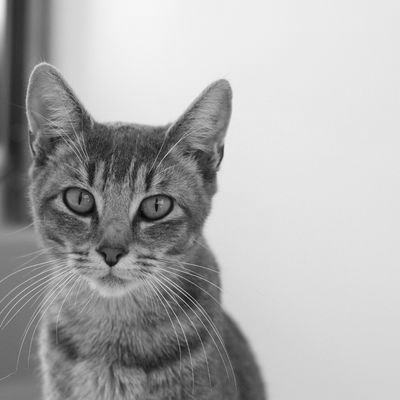

In [6]:
# g === area (big image)
# f === fragment
g = Image.open('img/catcare.jpg').convert('L')
g

In [7]:
g.size
g_mat = np.asarray(g.getdata(), dtype=np.int8).reshape(g.size[1], g.size[0])

(70, 70)


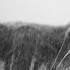

In [8]:
# Crop fragment from area image
xf = 100
yf = 100
wf = 70
hf = 70

crop_box = (xf, yf, xf + wf, yf + hf)
f = g.crop(crop_box)
print f.size
f

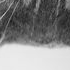

In [6]:
# Create matrix of fragment
f_mat = np.asarray(f.getdata(), dtype=np.int8).reshape(f.size[1], f.size[0])
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray(f_mat, 'L')

In [7]:
num_shades = 256
# Create indicators of f
# of size == g.size
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [8]:
# fill the indicators
for h in xrange(f.size[1]):
    for w in xrange(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

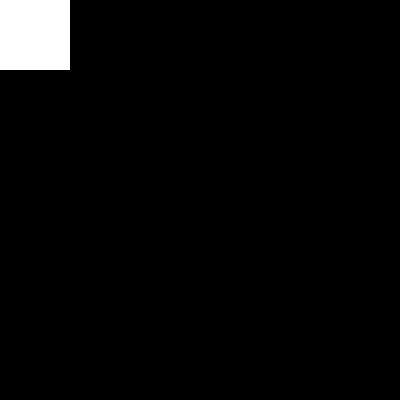

In [9]:
Image.fromarray(chi.sum(axis=0).astype('uint8')*(num_shades - 1), 'L')

In [10]:
# chi_elems[i] === number of pixels that have color "i"
chi_elems = np.array( f.histogram() )
print chi_elems

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   1   0   1   1   1   1   1   1
   1   3   5   3   5  10   8  12  11  22  22   6  17  24  17  34  27  42
  38  52  43  47  42  48  46  35  63  43  75  51  51  58  60  69  72  53
  58  56  60  43  46  51  49  43  44  51  42  42  44  36  44  41  44  37
  44  40  37  26  40  38  38  28  46  33  31  24  24  19  15  20  17  15
  16  16  13  21  16  28  15  18  10  17   8  12  11   8  11  11  14  12
  11  13   5   8  15   7   6  12   7   6   8   8   5  10   8   4   9   4
  10   7  11  12   7  11   7   5   7   5   9   3   3   6   4   6   3   5
   2   6   7   7   6   1   8   5   5   1   2   2   5   9   3   4   3   1
   3   4   7   5   3   3   1   1   2   3   5   2   1   3   2   4   6   4
   4   4   3   3   2   3   5   2   0   3   3   4   5   6   5   1   6   3
   1   1   2  12   6   6  14  23  45  72  81  80  95 141 157 119 175 188
 239 130   3   0   0   0   0   0   0   0   0   0   

In [11]:
fft_chi = np.fft.fft2(chi)

In [12]:
fft_g = np.fft.fft2(g_mat)

In [13]:
# Scalar product (g_frag, chi[i])
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

for i in xrange(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
# || Projection of g_frag on f ||^2
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in xrange(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])
        

norm_pr_gfrag_sqr = abs(norm_pr_gfrag_sqr)

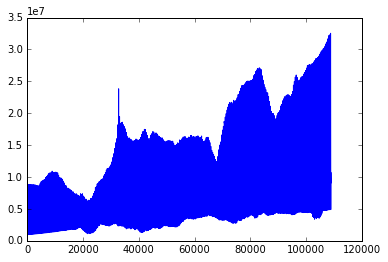

In [15]:
plt.plot(norm_pr_gfrag_sqr.ravel())

In [16]:
w_norm = norm_pr_gfrag_sqr.shape[1]
idx_pr = norm_pr_gfrag_sqr.argmax()
true_idx = xf + yf * w_norm
print 'idx Should be: ', true_idx
print idx_pr
print idx_pr // w_norm + 1, idx_pr % w_norm + 1

idx Should be:  33100
108734
330 165


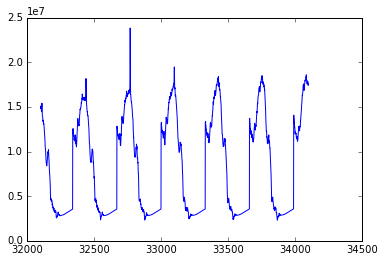

In [17]:
plt.plot(np.arange(true_idx - 1000, true_idx + 1000), norm_pr_gfrag_sqr.ravel()[true_idx - 1000 : true_idx + 1000])

In [18]:
# chi_X -- const field of vision
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))

# || g ||^2
fft_gsqr = np.fft.fft2(g_mat ** 2)
fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

norm_gfrag_sqr = abs(norm_gfrag_sqr)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


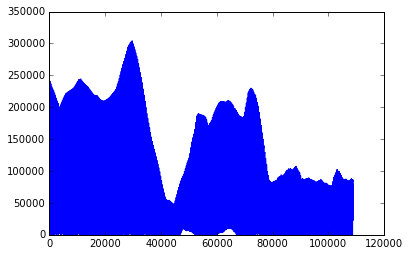

In [19]:
plt.plot(norm_gfrag_sqr.ravel())

In [20]:
# E_gfrag = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float')
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

norm_E_gfrag_sqr = abs(norm_E_gfrag_sqr)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


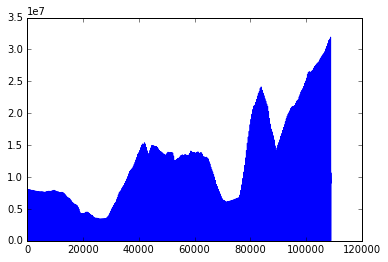

In [21]:
plt.plot(norm_E_gfrag_sqr.ravel())

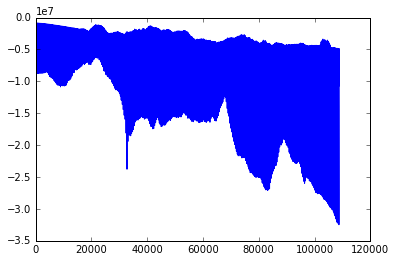

In [22]:
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())

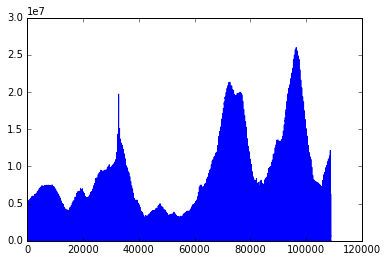

In [23]:
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr
plt.plot(denominator.ravel())

idx Should be:  32769
96419
293 60
100 100


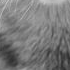

In [31]:
w_norm = norm_pr_gfrag_sqr.shape[1]
idx_denom = denominator.ravel().argmax()
true_idx = xf - 1 + (yf - 1) * w_norm
print 'idx Should be: ', true_idx
print idx_denom
y_denom, x_denom = idx_denom // w_norm + 1, idx_denom % w_norm + 1

print y_denom, x_denom
print yf, xf

Image.fromarray(g_mat[y_denom : y_denom + hf, x_denom : x_denom + wf], 'L')

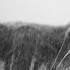

In [32]:
f

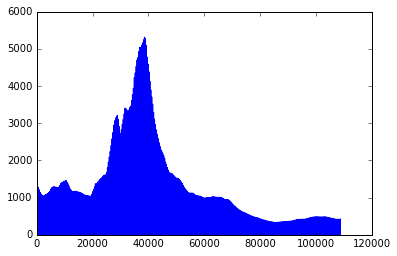

In [25]:
tau = abs(numerator) / abs(denominator)
plt.plot(tau.ravel())

In [26]:
index = tau.argmin() 
x_min = index % tau.shape[1] + 1
y_min = index // tau.shape[1] + 1
print index
print 'Should be:', true_idx
print "x_min, y_min: %d %d" % (y_min, x_min)
print 'Should be:', (yf, xf)

51012
Should be: 32769
x_min, y_min: 155 193
Should be: (100, 100)


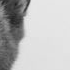

In [27]:
Image.fromarray(g_mat[y_min : y_min + hf , x_min : x_min + wf], 'L')